In [27]:
import numpy as np
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [50]:
def sim(r_0, drift, diffusion, N, T, N_paths):
    delta_t = T / N
    paths = np.full((N_paths, N+1), np.nan)
    paths[:, 0] = r_0
    for i in range(N):
        Z = np.random.normal(0, 1, N_paths)  # standard Brownian increments
        paths[:, i+1] = paths[:, i] - drift*paths[:, i]*delta_t + diffusion*np.sqrt(delta_t)*Z
    return paths


def get_phi(t, a, b, lambda_):
    return a + b*((1 - np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t))


def get_yield(r, N, delta_t=1/252, conf_alpha=0.05):
    T = N * delta_t
    bond_prices = np.exp(-delta_t * np.sum(r[:, 1:N+1], axis=1))
    bond_price = np.sum(bond_prices) / r.shape[0]
    bond_price_ci = np.std(bond_prices, ddof=1) * norm.ppf(1 - conf_alpha/2) / np.sqrt(r.shape[0])
    yield_rate = -np.log(bond_price) / T
    yield_rate_ci = (-np.log(bond_price - bond_price_ci) / T, -np.log(bond_price + bond_price_ci) / T)
    return yield_rate, yield_rate_ci

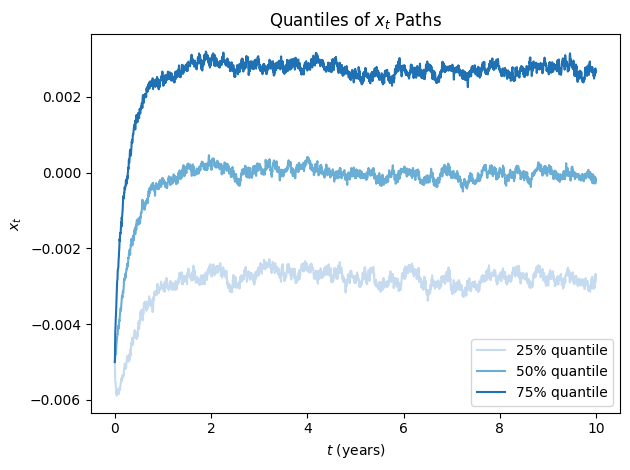

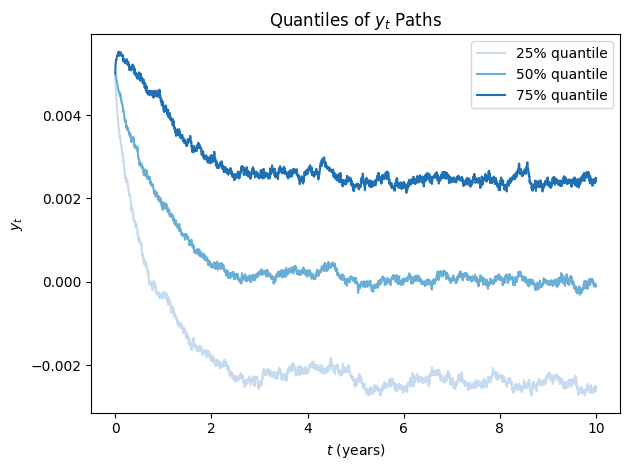

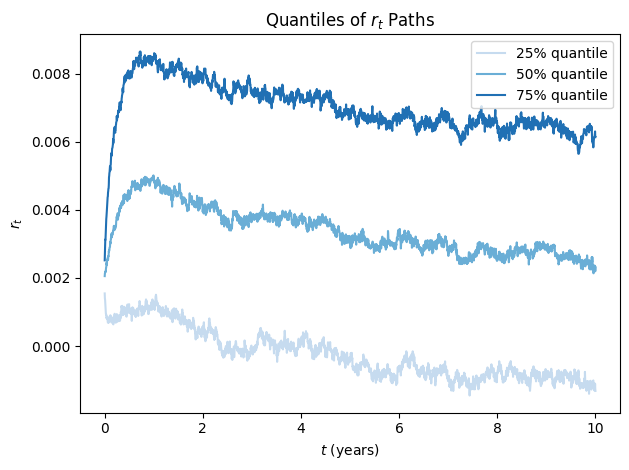

In [51]:
"""Q2 main run"""
np.random.seed(1928)

x_0 = -0.005
y_0 = 0.005
alpha = 3
beta = 1
sigma = 0.01
eta = 0.005
a = 0.002
b = 0.005
lambda_ = 0.75

t = np.linspace(0, 10, 2521)
phi = get_phi(t, a, b, lambda_)
x = sim(x_0, alpha, sigma, 2520, 10, 1000)
y = sim(y_0, beta, eta, 2520, 10, 1000)
r = phi + x + y

# fig, ax = plt.subplots()
# ax.plot(t, x[0], label=f"$x_t$")
# ax.plot(t, y[0], label=f"$y_t$")
# ax.plot(t, r[0], label=f"$r_t$")
# ax.set(xlabel='$t$ (years)', ylabel='rate')
# ax.set_title("Sample Paths of $x_t$, $y_t$, and $r_t$")
# ax.legend()
# plt.tight_layout()
# plt.show()
# fig.savefig("media/sample_paths.png")

quantiles = [0.25, 0.5, 0.75]  # [0.1, 0.25, 0.5, 0.75, 0.9]
cmap = matplotlib.cm.get_cmap('Blues')

fig, ax = plt.subplots()
for quantile in quantiles:
    ax.plot(t, np.quantile(x, quantile, axis=0), label=f"{int(quantile*100)}% quantile", color=cmap(quantile))
# ax.plot(t, x[-1], label=f"sample $x_t$ path", alpha=0.3, color='k')
ax.set(xlabel='$t$ (years)', ylabel='$x_t$')
ax.set_title("Quantiles of $x_t$ Paths")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/x_t.png")

fig, ax = plt.subplots()
for quantile in quantiles:
    ax.plot(t, np.quantile(y, quantile, axis=0), label=f"{int(quantile*100)}% quantile", color=cmap(quantile))
# ax.plot(t, y[-1], label=f"sample $y_t$ path", alpha=0.3, color='k')
ax.set(xlabel='$t$ (years)', ylabel='$y_t$')
ax.set_title("Quantiles of $y_t$ Paths")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/y_t.png")

fig, ax = plt.subplots()
for quantile in quantiles:
    ax.plot(t, np.quantile(r, quantile, axis=0), label=f"{int(quantile*100)}% quantile", color=cmap(quantile))
# ax.plot(t, r[-1], label=f"sample $r_t$ path", alpha=0.3, color='k')
ax.set(xlabel='$t$ (years)', ylabel='$r_t$')
ax.set_title("Quantiles of $r_t$ Paths")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/r_t.png")

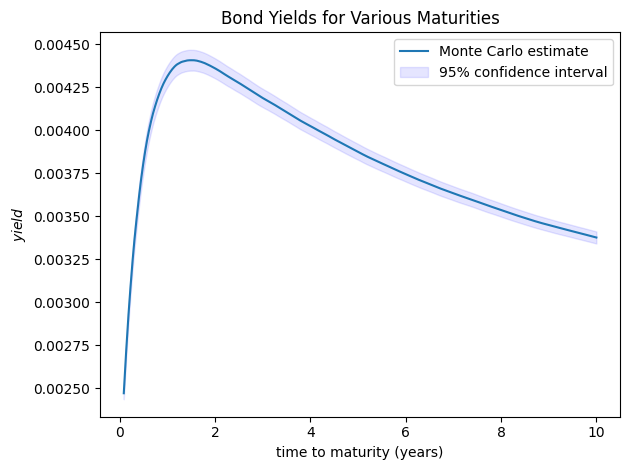

In [52]:
"""Q3 main run"""
x = sim(x_0, alpha, sigma, 2520, 10, 10000)
y = sim(y_0, beta, eta, 2520, 10, 10000)
r = phi + x + y

yields = np.full(2521, np.nan)
lower_cis = np.full(2521, np.nan)
upper_cis = np.full(2521, np.nan)
for i in range(21, 2521):  # 1 month (assuming each month has 21 trading days) ~ 10 years
    yields[i], (lower_cis[i], upper_cis[i]) = get_yield(r, i)

fig, ax = plt.subplots()
ax.plot(t, yields, label="Monte Carlo estimate")
ax.fill_between(t, lower_cis, upper_cis, color='b', alpha=.1, label="95% confidence interval")
ax.set(xlabel='time to maturity (years)', ylabel='$yield$')
ax.set_title("Bond Yields for Various Maturities")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/yield.png")

In [ ]:
"""Q4 main run"""
